In [1]:
import numpy as np
import pandas as pd
import itertools as it
from mne import read_epochs
from mne.filter import filter_data
import matplotlib.pylab as plt
from scipy.signal import savgol_filter
from scipy.spatial.distance import euclidean
from scipy.interpolate import interp2d, interp1d
from sklearn.preprocessing import minmax_scale

import trimesh
import slam.io as sio
import nibabel as nib
import matplotlib
from matplotlib import colors
matplotlib.use("Qt5Agg")

from freesurfer_tools import transform_atlas
import new_files

In [2]:
def compute_csd(surf_tcs, times, mean_dist, n_surfs):
    # Compute CSD
    nd=1;
    spacing=mean_dist*10**-3

    csd=np.zeros((n_surfs, surf_tcs.shape[1]))
    for t in range(surf_tcs.shape[1]):
        phi=surf_tcs[:,t]
        csd[0,t]=surf_tcs[0,t]
        csd[1,t]=surf_tcs[1,t]
        for z in range(2,n_surfs-3):
            csd[z,t]=(phi[z+2]-2*phi[z]+phi[z-2])/((nd*spacing)**2)
        csd[-2,t]=surf_tcs[-2,t]
        csd[-1,t]=surf_tcs[-1,t]            
    
    return csd

def csd_layer(data, mean_distance, n_surfs, nd=1):
    spacing = mean_distance*10*1e-3
    output_shape = data.shape
    csd = np.zeros(output_shape)
    for t in range(output_shape[1]):
        phi = data[:, t]
        csd[0, t] = data[0, t]
        csd[1, t] = data[1, t]
        for z in range(2, n_surfs-3):
            csd[z, t] = (phi[z+2]-2*phi[z-2])/((nd*spacing)**2)
        csd[-2, t] = data[-2, t]
        csd[-1, t] = data[-1, t]  
    return csd


def smooth_csd(csd, n_surfs):
    # interpolate CSD in space
    y = np.linspace(0,n_surfs-1,n_surfs)
    Yi=np.linspace(0,n_surfs-1,500)
    
    f=interp1d(y,csd,kind='cubic',axis=0)
    csd_smooth=f(Yi)
    
    csd_smooth=savgol_filter(csd_smooth, 51, 3, axis=1)
    
    return csd_smooth

In [3]:
files = new_files.Files()

In [4]:
tsv_paths = files.get_files(
    "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/ses-01/inverse/",
    "*.tsv", prefix="multilayer_MU"
)

epo_paths = files.get_files(
    "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/ses-01/",
    "*.fif", strings=["autoreject", "sub-001", "visual1", "001-v"], 
)

annot_paths = [
    "/home/mszul/git/DANC_multilayer_laminar/assets/lh.HCPMMP1.annot",
    "/home/mszul/git/DANC_multilayer_laminar/assets/rh.HCPMMP1.annot"
]
fsavg_sphere_paths = [
    "/home/mszul/git/DANC_multilayer_laminar/assets/lh.sphere.reg.gii",
    "/home/mszul/git/DANC_multilayer_laminar/assets/rh.sphere.reg.gii"
]
fsnat_sphere_paths = [
    "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/lh.sphere.reg.gii",
    "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/rh.sphere.reg.gii"
]

pial_path = "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/pial.gii"
pial_ds_path = "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/pial.ds.gii"
pial_ds_nodeep = "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/pial.ds.link_vector.nodeep.gii"
pial_ds_inflated = "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/pial.ds.inflated.nodeep.gii"
white_ds_nodeep = "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/white.ds.link_vector.nodeep.gii"

glasser = "/home/mszul/git/DANC_multilayer_laminar/assets/atlas_glasser_2016.csv"

In [5]:
MU_filt = pd.read_csv(tsv_paths[0], sep="\t", header=None)
MU_nofilt = pd.read_csv(tsv_paths[1], sep="\t", header=None)
epochs = read_epochs(epo_paths[0], verbose=False)
epochs = epochs.pick_types(meg=True, ref_meg=False, misc=False)
epochs_info = epochs.info
epochs_times = epochs.times
epochs = epochs.get_data()
mesh_colors, lab_col_map = transform_atlas(annot_paths, fsavg_sphere_paths, fsnat_sphere_paths, pial_path, pial_ds_path, pial_ds_nodeep)
atlas = pd.read_csv(glasser)
target_labels = atlas[
    (atlas.PRIMARY_SECTION == 1) | 
    (atlas.PRIMARY_SECTION == 2) |
    (atlas.USED_LABEL == "L_MT_ROI") | 
    (atlas.USED_LABEL == "R_MT_ROI")
].USED_LABEL.to_list()
ROI_maps = {i: [i == j.decode("utf=8") for j in lab_col_map] for i in target_labels}
MU_filt_ROI = {k: MU_filt.to_numpy()[ROI_maps[k]*11,:] for k in ROI_maps.keys()}
MU_nofilt_ROI = {k: MU_nofilt.to_numpy()[ROI_maps[k]*11,:] for k in ROI_maps.keys()}

In [6]:
ROI = "L_V1_ROI"

In [7]:
source_loc = np.array([np.dot(MU_filt_ROI[ROI], i) for i in epochs])
source_loc = np.split(source_loc, 11, axis=1)

In [8]:
pial_ds_loc = nib.load(pial_ds_nodeep).agg_data()[0][ROI_maps[ROI]]
white_ds_loc = nib.load(white_ds_nodeep).agg_data()[0][ROI_maps[ROI]]
distance_ROI = np.array([euclidean(pial_ds_loc[i], white_ds_loc[i]) for i in range(pial_ds_loc.shape[0])])

In [9]:
distance_normed = minmax_scale(np.append(distance_ROI, 0))
distance_normed = distance_normed[:-1]
vtx_col = np.tile([220, 220, 220, 255], [lab_col_map.shape[0], 1])
vtx_col[ROI_maps[ROI]] = trimesh.visual.interpolate(distance_normed, color_map="Reds")
inflated = sio.load_mesh(pial_ds_inflated)
inflated.visual.vertex_colors = vtx_col

top_vxs = np.concatenate([
    np.argpartition(distance_normed, -4)[-4:], 
    np.argpartition(distance_normed, 4)[:4]
])
top_vxs_colours = np.concatenate([
    np.tile(np.array([15, 10, 222, 255]), (4,1)), 
    np.tile(np.array([255, 240, 0, 255]), (4,1))
])

spheres = []
for ix, vx in enumerate(top_vxs):
    peak_vertex = np.arange(len(ROI_maps[ROI]))[ROI_maps[ROI]][vx]
    peak_loc = np.array(inflated.vertices[peak_vertex])
    sphere = trimesh.creation.uv_sphere(radius=1)
    sphere.visual.vertex_colors = top_vxs_colours[ix]
    sphere.apply_translation(peak_loc)
    spheres.append(sphere)
    
scene = trimesh.Scene([inflated] + spheres)
scene.show(viewer="notebook")

/tmp/ipykernel_4152/3935785750.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  csd[z, t] = (phi[z+2]-2*phi[z-2])/((nd*spacing)**2)
/home/mszul/miniconda3/envs/mne/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_4152/3935785750.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  csd[z, t] = (phi[z+2]-2*phi[z-2])/((nd*spacing)**2)
/home/mszul/miniconda3/envs/mne/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


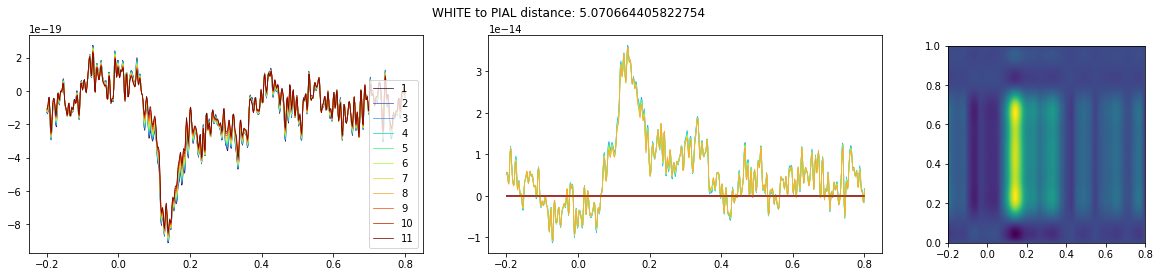

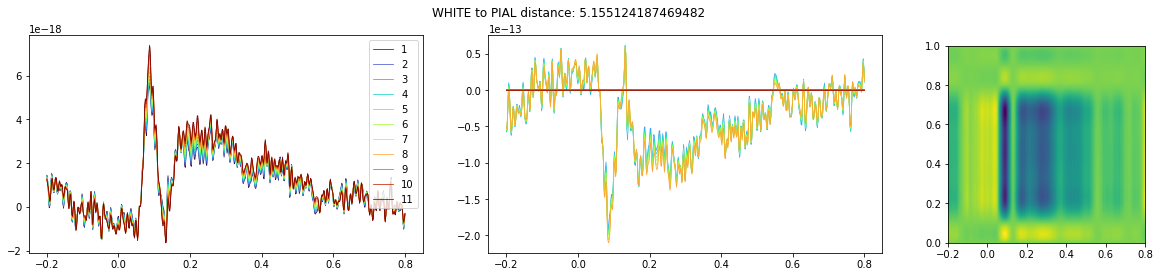

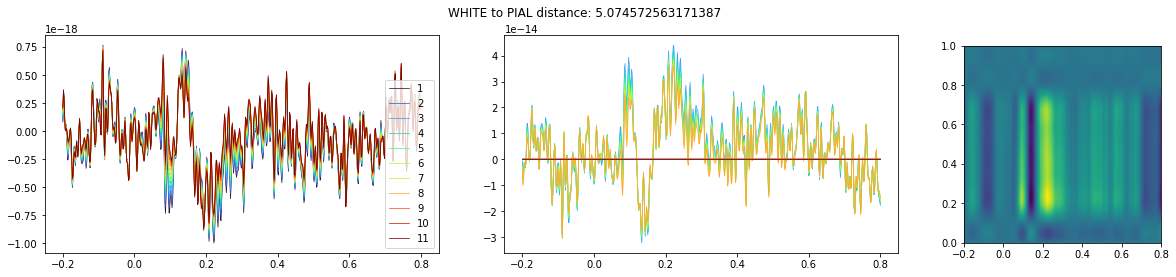

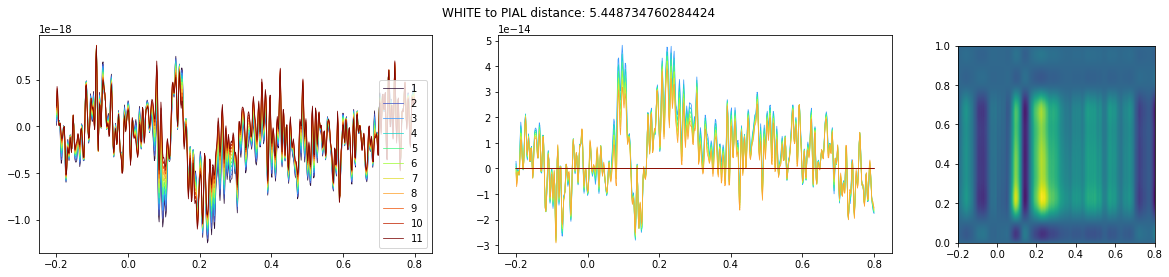

/home/mszul/miniconda3/envs/mne/lib/python3.9/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/mszul/miniconda3/envs/mne/lib/python3.9/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


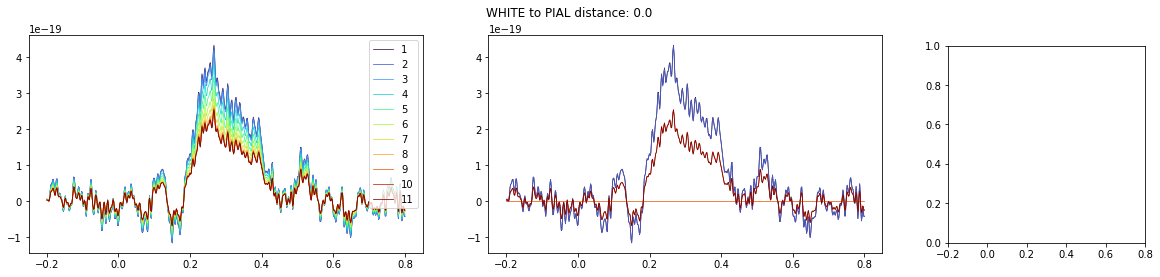

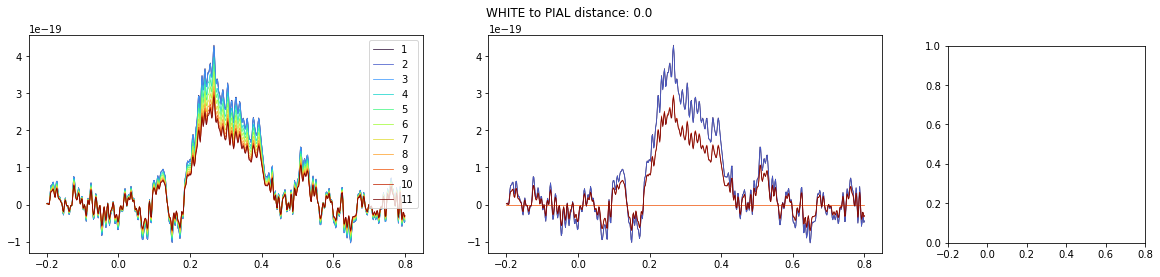

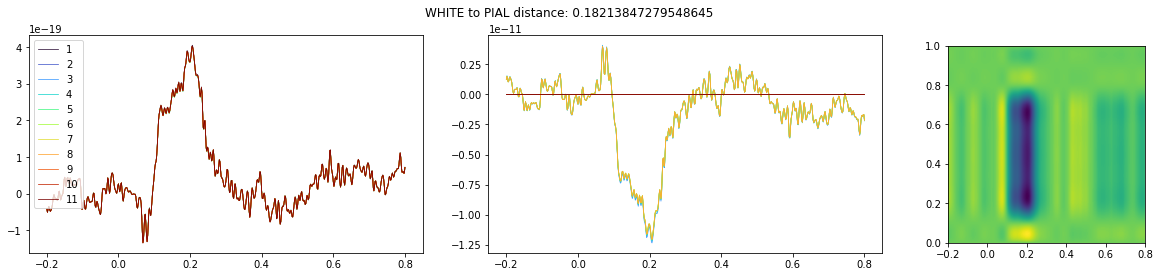

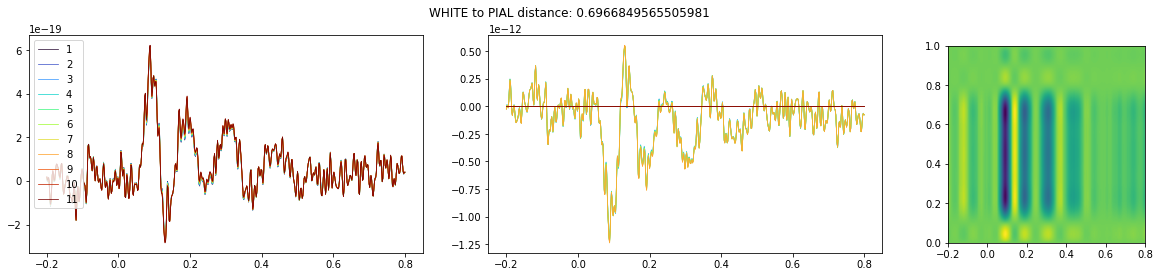

In [11]:
%matplotlib inline
for ix, vx in enumerate(top_vxs):
    data = [i[:, vx, :] for i in source_loc]
    data_csp = np.array(data[::-1]) # inverting the order of layers
    data_csp = [data_csp[:,i,:] for i in range(data_csp.shape[1])]
    n_surfs = 11
    mean_distance = distance_ROI[vx] / (n_surfs -1)
    colour_range = plt.cm.turbo(np.linspace(0, 1, num=n_surfs))
    all_csd = [csd_layer(i, mean_distance, n_surfs) for i in data_csp]
    all_smooth_csd = [smooth_csd(i, n_surfs) for i in all_csd]
    mean_layer = np.mean(data_csp, axis=0)
    mean_csd = np.mean(all_csd, axis=0)
    mean_smooth_csd = np.mean(all_smooth_csd, axis=0)
    f, ax = plt.subplots(1, 3, figsize=(20,4), gridspec_kw={'width_ratios': [0.4, 0.4, 0.2]})
    for surf in range(n_surfs):
        ax[0].plot(epochs_times, mean_layer[surf], lw=0.75, c=colour_range[surf], label=surf+1)
        ax[1].plot(epochs_times, mean_csd[surf], lw=0.75, c=colour_range[surf])
    ax[2].imshow(mean_smooth_csd, origin="lower", extent=[epochs_times[0], epochs_times[-1], 0, 1])
    ax[0].legend();
    f.suptitle("WHITE to PIAL distance: {}".format(distance_ROI[vx]))